In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd

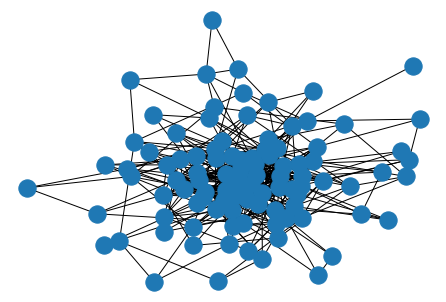

In [2]:



sizes = [50,50] # sizes of blocks
probs = [[0.2, 0.05], [0.05, 0.05]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

nx.draw(G)

# G.graph['partition'][1] get nodes from 2nd stochastic block

In [3]:

def projection_simplex_pivot(v, z=1, random_state=None):
    rs = np.random.RandomState(random_state)
    n_features = len(v)
    U = np.arange(n_features)
    s = 0
    rho = 0
    while len(U) > 0:
        G = []
        L = []
        k = U[rs.randint(0, len(U))]
        ds = v[k]
        for j in U:
            if v[j] >= v[k]:
                if j != k:
                    ds += v[j]
                    G.append(j)
            elif v[j] < v[k]:
                L.append(j)
        drho = len(G) + 1
        if s + ds - (rho + drho) * v[k] < z:
            s += ds
            rho += drho
            U = L
        else:
            U = G
    theta = (s - z) / float(rho)
    return np.maximum(v - theta, 0)


def projection_simplex_sort(v, z=1):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u) - z
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(v - theta, 0)
    return w


def crit_b(J):
    eigenvalues,_ = np.linalg.eig(J)
    return 1./np.max(np.abs(eigenvalues))

def average_degree(G,control,budget):
    return np.sum([G.degree[i]*con for i,con in enumerate(control)])/budget


In [10]:
        
class mf_ising_system:

    def __init__(self,graph,background_field,fixed_point_iter=500,init_mag='aligned',fp_tol_fac=10-6,
        iim_iter=1000,step_size=1.0,iim_tol_fac=1e-5):
        
        self.graph = graph
        self.adj_matrix = nx.to_numpy_matrix(graph)
        self.graph_size = len(graph.nodes.keys())
        self.background_field = background_field
        self.fixed_point_iter=fixed_point_iter
        self.iim_iter = iim_iter
        self.fp_tol_fac=fp_tol_fac
        self.iim_tol_fac=iim_tol_fac
        self.step_size=step_size
        if init_mag=='aligned':
            self.init_mag=np.zeros(self.graph_size)
        else:
            self.init_mag = init_mag 
            
        
    def single_mag(self,i,m,beta,field):
        gamma=1.0
        spin_field = np.dot(self.adj_matrix[i],m)
        term = math.tanh(beta*(spin_field+field[i]))
        return (1.0-gamma)*m[i] + gamma*term
    
    def magnetisation(self,mag,beta,field):
        m_old = mag
        m_new = np.zeros(len(m_old))
        for i in range(system.graph_size):
            m_new[i]=system.single_mag(i,m_old,beta,field)
        return m_new

    def Steffensen_method(self,mag,beta,field,mag_delta_history=[],it=0,heuristics=False):      
        # Numerical Analysis Richard L.Burden 9th Edition, p. 107
        if len(mag_delta_history)==0 or heuristics==True:
            mag0=mag
        else:
            mag0=mag_delta_history[it]
        
        for i in range(self.fixed_point_iter):     
            mag1=self.magnetisation(mag0,beta,field)
            mag2=self.magnetisation(mag1,beta,field)
            
            if np.all((mag+mag2-2*mag1)!=0):
                mag_d = mag - (mag1-mag)**2/(mag+mag2-2*mag1) 
            else:
                mag_d = mag1
            
                    
            if np.abs(np.mean(mag1)-np.mean(mag_d))<self.fp_tol_fac: 
                break
            if i+1==self.fixed_point_iter:
                print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.')
                mag_d = mag1
                if heuristics==True:
                    mag_d = None
                
        mag_delta_history.append(mag_d)
        return mag_d,mag_delta_history
    
    def mag_grad(self,beta,mag):
        # Mean Field Susceptibility;
        
        if all([math.isclose(i,j,abs_tol=1e-5) for i,j in zip(mag,np.ones(len(mag)))]):
            gradient = np.zeros(len(mag))
        else:
            D=np.identity(self.graph_size)*np.array([(1-i**2) for i in mag]) # equals to 0 if all m's are 1 or close to 1
            inv = np.linalg.inv(np.identity(self.graph_size)-beta*D*self.adj_matrix)
            susc_matrix = beta*inv*D
            gradient = np.sum(susc_matrix,axis=1).A1
            gradient = (1.0 / np.linalg.norm(gradient))*gradient #Normalise

        return gradient
    
    
    def MF_IIM(self,field_budget,beta,init_control_field='uniform'):
              
        if init_control_field=='uniform':
            control_field = (field_budget/self.graph_size)*np.ones(self.graph_size)
        else:
            control_field = init_control_field

        # initial magnetisation as influenced by initial budget spread
        # note: different from init_mag which denotes initial magnetisation *without* the external field      
        tot_field = np.array(self.background_field+control_field)

        control_field_history=[]
        control_field_history.append(control_field)
        mag_delta_history=[]
        
        mag_i,mag_delta_history = self.Steffensen_method(self.init_mag,beta,tot_field,mag_delta_history,0)
        
        for it in range(self.iim_iter):
            
            if field_budget!=0:
                mag_i_grad = self.mag_grad(beta,mag_i)
                control_field = control_field_history[it]
                
                control_field_update = (control_field - self.step_size*mag_i_grad) # gradient ascent
                control_field_new = -projection_simplex_sort(control_field_update.T,z=field_budget)
            else:
                control_field_new = np.zeros(system.graph_size)

            tot_field = np.array(self.background_field+control_field_new)
            mag_ii,mag_delta_history = self.Steffensen_method(mag_i,beta,tot_field,mag_delta_history,it)


            if np.abs(np.mean(mag_ii)-np.mean(mag_i)) <= self.iim_tol_fac:
                final_mag=mag_ii
                break
            control_field_history.append(control_field_new)
            mag_i=mag_ii
        if it==self.iim_iter-1:
            print('Failed to converge after {} iterations.'.format(self.iim_iter))
            final_mag = mag_ii
            
        return control_field,final_mag
    
            
        
                
budget=20.0
h = np.zeros(len(G.nodes.keys()))

system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=int(5*1e2),step_size=0.01)


beta_crit=crit_b(system.adj_matrix)
beta = beta_crit
control,final_mag=system.MF_IIM(budget,beta)


In [11]:
block1,block2 = np.sum(control[:50]),np.sum(control[50:])
print(block1,block2)


-9.949011529434241 -10.050988470565766


In [27]:
budget=20.0


beta_min = 0.5*beta_crit 
beta_max = 3*beta_crit 

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=50,endpoint=True,base=10)
y = np.zeros(len(beta_list))
control_history=np.zeros((len(beta_list),2))

normal_params = {'graph':G,'background_field':h,
                         'iim_iter':10000,'iim_tol_fac':1e-5,'fixed_point_iter':5000,
                         'step_size':12.0,'fp_tol_fac':10-4}


for i,beta in enumerate(beta_list):
    
    system = mf_ising_system(**normal_params)
        
    control,_=system.MF_IIM(budget,beta)
    block1,block2 = np.sum(control[:50]),np.sum(control[50:])
    control_history[i]=np.array([block1,block2])
        
    if i%10==0:
        print(i,beta)

print('FINISHED')    

0 0.04285309672488253
10 0.061771562768963256
20 0.08904201232916684
30 0.12835161689662014
Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.
Failed to converge after 10000 iterations.
Failed to converge after 10000 iterations.
40 0.18501533297648123
Failed to converge after 10000 iterations.
Failed to converge after 10000 iterations.
FINISHED


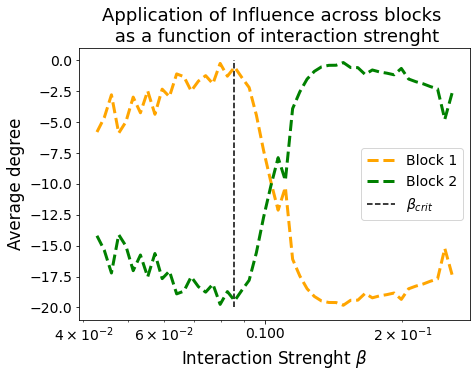

In [29]:
import matplotlib


matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(7,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})

# to_del =[80,81]
# control_history_edit= np.delete(control_history,to_del,axis=0)
# beta_list_edit = np.delete(beta_list,to_del,axis=0)


fig,ax = plt.subplots()

ax.plot(beta_list,control_history[:,0],c='orange',label='Block 1',linestyle='dashed',linewidth=3)
ax.plot(beta_list,control_history[:,1],c='green',label='Block 2',linestyle='dashed',linewidth=3)

ax.set_xscale(value='log')

plt.locator_params(axis='x',numticks=10)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.vlines(beta_crit,ymin=-20,ymax=0,linestyles='dashed',color='black',label=r'$\beta_{crit}$')
ax.set_xlabel(r'Interaction Strenght $\beta$')
ax.set_title('Application of Influence across blocks \n as a function of interaction strenght')
ax.legend()
plt.show()


In [115]:
class monte_carlo_simulations:
    def __init__(self,graph,background_field):
        self.graph = graph
        self.graph_size = len(self.graph.nodes())
        self.adj_matrix = nx.to_numpy_matrix(graph)
        half_size = int(self.graph_size/2)
        spins = np.concatenate([np.ones(half_size),(-1)*np.ones(half_size)])
        np.random.shuffle(spins)
        self.init_spins = spins
        self.background_field = background_field
        
mc_system = monte_carlo_simulations(G,h)

In [213]:
from networkx.algorithms.centrality import closeness_centrality
import random 
import sys

def fixed_point(system,total_field,beta=beta_crit):
    mag_old = system.init_mag
    for it in range(system.fixed_point_iter):
        mag_new = system.magnetisation(mag_old,beta,total_field)
        if np.abs(np.mean(mag_new)-np.mean(mag_old))<system.fp_tol_fac: 
            break
        mag_old = mag_new
        if i+1==self.fixed_point_iter:
            print('Failed to solve self-consistency equation. Consider increasing fixed_point_iter parameter.')
    return mag_new


    
def monte_carlo_metropolis(system,control,T=500,beta=beta_crit):
    total_mag_history = np.zeros((T,system.graph_size))
    mag_old = system.init_spins
    for it in range(T):
        spin_int = random.randint(0,len(system.init_spins)-1)
        surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)

        delta_e = 2*mag_old[spin_int]*(surr_spin+control[spin_int])
        if delta_e > 0:
            prob=np.exp( -1.0*beta*delta_e)
        else:
            prob = 1.0
        random_prob = random.uniform(0, 1)
        
        if random_prob <=prob:
            mag_rev = (-1)*mag_old[spin_int]
            mag_old[spin_int] = mag_rev
        total_mag_history[it] = mag_old

    return np.sum(total_mag_history,axis=1)

def run_MC(system,control,T,MC,beta=beta_crit):
    time_averaged_mag = np.zeros(MC)
    for it in range(MC):
        sample = monte_carlo_metropolis(system,control,T,beta)
        time_averaged_mag[it]=np.mean(sample)
        
        
    mag_final = np.mean(time_averaged_mag)
    return mag_final
        


def degree(system,budget,T,MC,beta=beta_crit):
    sum_degree = np.sum([system.graph.degree[node] for node in system.graph.nodes])
    control_field = np.array([(system.graph.degree[node]/sum_degree)*budget for node in system.graph.nodes])
    

    assert np.round(np.sum(control_field),3)==budget

    tot_field = np.array(system.background_field+control_field)
    
    mag=run_MC(system,tot_field,T,MC,beta=beta_crit)
    #mag=fixed_point(system,tot_field,beta)


    return mag

def centrality(system,budget,T,MC,beta=beta_crit):
    centrality = closeness_centrality(system.graph)
    sum_centrality=sum(centrality.values())
    control_field = np.array([(centrality[node]/sum_centrality)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    #mag=fixed_point(system,tot_field)
    mag=run_MC(system,tot_field,T,MC,beta=beta_crit)


    return mag


def random_set(system,budget,T,MC,beta=beta_crit):
    random_arr = [int(100*random.random()) for i in range(system.graph_size)]
    random_dic = {i:k for i,k in zip(system.graph.nodes,random_arr)}
    sum_random = np.sum(random_arr)
    control_field = np.array([(random_dic[node]/sum_random)*budget for node in system.graph.nodes])
    
    assert np.round(np.sum(control_field),3)==budget
    
    tot_field = np.array(system.background_field+control_field)
    #mag=fixed_point(system,tot_field)
    mag=run_MC(system,tot_field,T,MC,beta=beta_crit)

    
    return mag


In [214]:
budget = 40
mc_system = monte_carlo_simulations(G,h)
mag = centrality(mc_system,budget,1000,200)



print(mag)

18.290319999999998


In [215]:
budgets = np.arange(0,40,5)
system = mf_ising_system(G,h,iim_iter=1000,fixed_point_iter=1000,step_size=1.76)



T = 5000
MC = 500
all_types={'MF':[],'Central':[],'Random':[],'Degree':[]}

for budget in budgets:
    print(budget)
    #print('MF')
    control,final_mag=system.MF_IIM(budget,beta_crit)
    mag_mf = np.sum(final_mag)
    all_types['MF'].append(mag_mf)
    
    #print('Central')
    mag_c= centrality(mc_system,budget,T,MC)
    all_types['Central'].append(mag_c)

    #print('Degree')
    mag_d = degree(mc_system,budget,T,MC)
    all_types['Degree'].append(mag_d)

    #print('Random')
    mag_r= random_set(mc_system,budget,T,MC)
    all_types['Random'].append(mag_r)




0
5
10
15
20
25
30
35


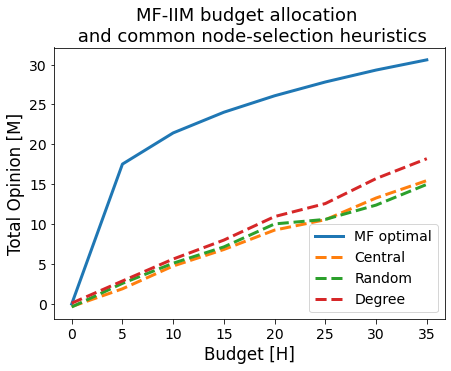

In [216]:
fig,ax=plt.subplots()
lw=3
ax.plot(budgets,all_types['MF'],label='MF optimal',linewidth=lw)
ax.plot(budgets,all_types['Central'],label='Central',linestyle='dashed',linewidth=lw)
ax.plot(budgets,all_types['Random'],label='Random',linestyle='dashed',linewidth=lw)
ax.plot(budgets,all_types['Degree'],label='Degree',linestyle='dashed',linewidth=lw)
ax.set_xlabel('Budget [H]')
ax.set_ylabel('Total Opinion [M]')
ax.set_title('MF-IIM budget allocation \n and common node-selection heuristics')
ax.legend()
plt.show()

In [105]:
def monte_carlo(system,control,repeat_factor=500,beta=beta_crit):
    total_mag_history = np.zeros(repeat_factor)
    mag_old = system.init_spins
    
    for jt in range(repeat_factor):
        for it in range(system.graph_size):
            spin_int = random.randint(0,len(system.init_spins)-1)
            surr_spin = float(system.adj_matrix[spin_int,:]@mag_old)    
            hamiltonian = lambda mag: -(mag[spin_int]*(surr_spin+control[spin_int]))
            mag_rev = (-1)*mag_old[spin_int]
            mags_trial = mag_old
            mags_trial[spin_int] = mag_rev
            w = np.exp( -beta*(hamiltonian(mags_trial) - hamiltonian(mag_old)) )
            prob = random.uniform(0, 1)
            
            if prob <=w:
                mags_old = mags_trial
            else:
                continue
        total_mag = np.sum(mag_old)
        total_mag_history[jt] = total_mag
        if len(total_mag_history)>11:
            previous_average_mag=np.mean(total_mag_history[jt-10:jt-1])
        else:
            previous_average_mag = np.mean(total_mag_history[0,jt-1])
        if np.abs(total_mag-previous_average_mag)<1e-5:
            mag_final = total_mag
            break
        if (jt+1)==repeat_factor:
            print('Failed to stabilise.')
            mag_final = total_mag
    return mag_final

    
    

52.54822922215996